<a href="https://colab.research.google.com/github/jaydent22/661-final-project/blob/main/t5/661_T5_SST2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T5 SST-2

This notebook will fine-tune a pretrained T5 model on the Stanford Sentiment Treebank dataset. The performance of the model will serve as one of the baselines with which to compare the performances of the autoregressive models on text classification.

## Setup

In [ ]:
!pip install transformers datasets pytorch-lightning

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from transformers import T5TokenizerFast, T5ForConditionalGeneration, T5ForSequenceClassification, AdamW, get_linear_schedule_with_warmup, Trainer, TrainingArguments
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from time import time

In [ ]:
cuda = torch.device('cuda')

In [ ]:
model_size = "base"

### Dataset

In [124]:
dataset = load_dataset("sst2")
print(type(dataset))

<class 'datasets.dataset_dict.DatasetDict'>


In [125]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})


In [126]:
for i, val in enumerate(dataset['train']):
    print(val)
    if i == 10:
        break

{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}
{'idx': 1, 'sentence': 'contains no wit , only labored gags ', 'label': 0}
{'idx': 2, 'sentence': 'that loves its characters and communicates something rather beautiful about human nature ', 'label': 1}
{'idx': 3, 'sentence': 'remains utterly satisfied to remain the same throughout ', 'label': 0}
{'idx': 4, 'sentence': 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ', 'label': 0}
{'idx': 5, 'sentence': "that 's far too tragic to merit such superficial treatment ", 'label': 0}
{'idx': 6, 'sentence': 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ', 'label': 1}
{'idx': 7, 'sentence': 'of saucy ', 'label': 1}
{'idx': 8, 'sentence': "a depressed fifteen-year-old 's suicidal poetry ", 'label': 0}
{'idx': 9, 'sentence': "are more deeply thought through than in most ` right-thinking 

## T5 Sequence Classification

Performance of sequence classification will be measured as a baseline metric for general sentiment analysis.

### Tokenizer

In [ ]:
tokenizer = T5TokenizerFast.from_pretrained(f"t5-{model_size}")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def tokenize_data(data):
  # data["label"] = data["label"].astype(np.float32)
  return tokenizer(
      data["sentence"],
      padding="max_length",
      truncation=True,
      max_length=128,
      return_tensors="pt"
  )

In [ ]:
tokenized_dataset = dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})


In [ ]:
for i, val in enumerate(tokenized_dataset['train']):
    print(val)
    if i == 10:
        break

{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0, 'input_ids': [7387, 126, 2829, 2865, 45, 8, 21555, 3173, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'idx': 1, 'sentence': 'contains no wit , only labored gags ', 'label': 0, 'input_ids': [2579, 

In [ ]:
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

### Dataset split

In [ ]:
train_ds = tokenized_dataset["train"]
val_ds = tokenized_dataset["validation"]

In [ ]:
unique, counts = np.unique(train_ds['label'], return_counts=True)
print(dict(zip(unique, counts)))

{0: 29780, 1: 37569}


In [ ]:
batch_size = 32
num_workers = 4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

### Training

In [ ]:
model = T5ForSequenceClassification.from_pretrained(f"t5-{model_size}", num_labels=1)
model.to(cuda)
print(model)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_feat

In [ ]:
epochs = 5
optimizer = AdamW(model.parameters(), lr=1e-6)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
len(train_loader)

2105

In [ ]:
loss_interval = len(train_loader) // 5
model.train()
t0 = time()
for epoch in range(epochs):
  total_loss = 0.0
  for i, batch in enumerate(train_loader):
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = loss_fn(outputs.logits.squeeze(), labels.float())
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
    if i % loss_interval == (loss_interval - 1):
      print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(train_loader)}, Loss: {total_loss / 100.0:.3f}")
      total_loss = 0.0
      print(f"Time elapsed: {time()-t0:.3f}s")
  # model.eval()
  # with torch.no_grad():
  #   correct = 0
  #   total = 0
  #   for batch in val_loader:
  #     input_ids = batch["input_ids"].to(cuda)
  #     attention_mask = batch["attention_mask"].to(cuda)
  #     labels = batch["label"].to(cuda)
  #     outputs = model(input_ids=input_ids, attention_mask=attention_mask)
  #     preds = torch.round(torch.sigmoid(outputs.logits))
  #     total += labels.size(0)
  #     correct += (preds.squeeze() == labels).sum().item()
  #   print(f"Epoch {epoch+1}/{epochs}, Validation Accuracy: {correct / total:.3f}")
print("Training finished")

Epoch 1/5, Batch 1/2105, Loss: 0.007
Time elapsed: 0.512s
Epoch 1/5, Batch 422/2105, Loss: 2.900
Time elapsed: 160.992s
Epoch 1/5, Batch 843/2105, Loss: 2.847
Time elapsed: 321.425s
Epoch 1/5, Batch 1264/2105, Loss: 2.791
Time elapsed: 481.894s
Epoch 1/5, Batch 1685/2105, Loss: 2.710
Time elapsed: 642.350s
Epoch 2/5, Batch 1/2105, Loss: 0.006
Time elapsed: 802.834s
Epoch 2/5, Batch 422/2105, Loss: 2.513
Time elapsed: 963.269s
Epoch 2/5, Batch 843/2105, Loss: 2.316
Time elapsed: 1123.734s
Epoch 2/5, Batch 1264/2105, Loss: 2.066
Time elapsed: 1284.223s
Epoch 2/5, Batch 1685/2105, Loss: 1.702
Time elapsed: 1444.702s
Epoch 3/5, Batch 1/2105, Loss: 0.003
Time elapsed: 1605.169s
Epoch 3/5, Batch 422/2105, Loss: 1.256
Time elapsed: 1765.673s
Epoch 3/5, Batch 843/2105, Loss: 1.161
Time elapsed: 1926.125s
Epoch 3/5, Batch 1264/2105, Loss: 1.108
Time elapsed: 2086.579s
Epoch 3/5, Batch 1685/2105, Loss: 1.075
Time elapsed: 2247.031s
Epoch 4/5, Batch 1/2105, Loss: 0.002
Time elapsed: 2407.502s
Epo

### Inference

In [ ]:
model.eval()
with torch.no_grad():
  all_preds = []
  all_labels = []
  for batch in val_loader:
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.round(torch.sigmoid(outputs.logits))
    all_preds.extend(preds.squeeze().tolist())
    all_labels.extend(labels.tolist())
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       428
           1       0.90      0.93      0.92       444

    accuracy                           0.91       872
   macro avg       0.91      0.91      0.91       872
weighted avg       0.91      0.91      0.91       872



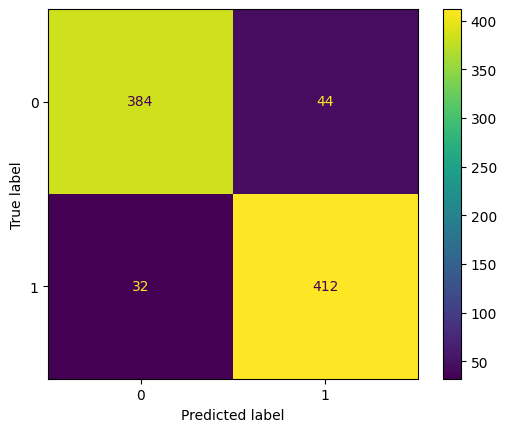

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

0.9125620948050854


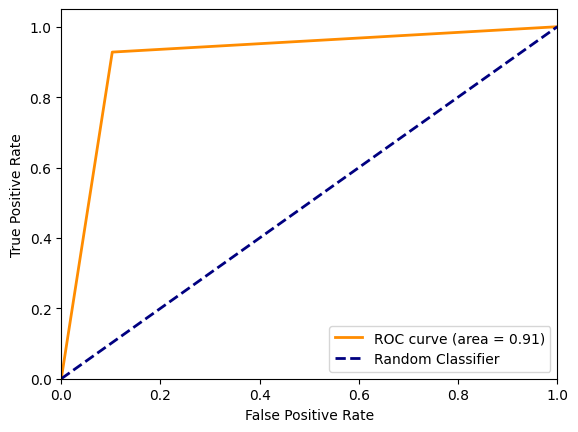

In [ ]:
tpr, fpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(tpr, fpr)
print(roc_auc)
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()

In [ ]:
torch.save(model.state_dict(), f"t5-{model_size}-sst2-classification.pt")

In [36]:
from google.colab import files

# Specify the local path of the file
local_file_path = '/content/t5-base-sst2-classification.pt'

# Trigger the file download
# files.download(local_file_path)

# print("Download started")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started


## T5 Conditional Generation

Performance of conditional generation will also be measured, as it more closely resembles the sentiment generation for the autoregressive models.

In [37]:
torch.cuda.empty_cache()

### Tokenizer

In [127]:
prefix = "Classify if the following is positive or negative: "
train_ds = dataset["train"]
val_ds = dataset["validation"]
train_ds = train_ds.map(lambda x: {"sentence": prefix + x["sentence"]})
val_ds = val_ds.map(lambda x: {"sentence": prefix + x["sentence"]})

# val_ds = val_ds.map(lambda x: {"sentence": prefix + x["sentence"]})
# val_ds = val_ds.map(lambda x: {"label": "positive" if x["label"] == 1 else "negative"})
  # for i in range(len(dataset[split]["sentence"])):
  #   dataset[split]["sentence"][i] = prefix + dataset[split]["sentence"][i]

In [128]:
label_map = {
    0: "negative",
    1: "positive"
}

def map_labels(data):
  data["sentiment"] = label_map[data["label"]]
  return data

train_ds = train_ds.map(map_labels)
val_ds = val_ds.map(map_labels)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [129]:
for i, val in enumerate(train_ds):
    print(val)
    if i == 10:
        break

{'idx': 0, 'sentence': 'Classify if the following is positive or negative: hide new secretions from the parental units ', 'label': 0, 'sentiment': 'negative'}
{'idx': 1, 'sentence': 'Classify if the following is positive or negative: contains no wit , only labored gags ', 'label': 0, 'sentiment': 'negative'}
{'idx': 2, 'sentence': 'Classify if the following is positive or negative: that loves its characters and communicates something rather beautiful about human nature ', 'label': 1, 'sentiment': 'positive'}
{'idx': 3, 'sentence': 'Classify if the following is positive or negative: remains utterly satisfied to remain the same throughout ', 'label': 0, 'sentiment': 'negative'}
{'idx': 4, 'sentence': 'Classify if the following is positive or negative: on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ', 'label': 0, 'sentiment': 'negative'}
{'idx': 5, 'sentence': "Classify if the following is positive or negative: that 's far too tragic to merit such superficial tre

In [130]:
def tokenize_data(data):
  inputs = tokenizer(
      data["sentence"],
      padding="max_length",
      truncation=True,
      max_length=100,
      return_tensors="pt"
  )
  labels = tokenizer(
      data["sentiment"],
      padding="max_length",
      truncation=True,
      max_length=2,
      return_tensors="pt"
  )
  inputs["label"] = labels["input_ids"]
  return inputs

In [131]:
train_tokenized = train_ds.map(tokenize_data, batched=True)
val_tokenized = val_ds.map(tokenize_data, batched=True)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [132]:
for i, val in enumerate(train_tokenized):
    print(val)
    if i == 10:
        break

{'idx': 0, 'sentence': 'Classify if the following is positive or negative: hide new secretions from the parental units ', 'label': [2841, 1], 'sentiment': 'negative', 'input_ids': [4501, 4921, 3, 99, 8, 826, 19, 1465, 42, 2841, 10, 7387, 126, 2829, 2865, 45, 8, 21555, 3173, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'idx': 1, 'sentence': 'Classify if the following is positive or negative: contains no wit , only labored gags ', 'label': [2841, 1], 'sentiment': 'negative', 'i

In [136]:
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [137]:
unique, counts = np.unique(train_tokenized['label'], return_counts=True)
print(dict(zip(unique, counts)))

{1: 67349, 1465: 37569, 2841: 29780}


In [138]:
batch_size = 32
num_workers = 4
train_loader = DataLoader(train_tokenized, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_tokenized, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

## Training

In [145]:
model = T5ForConditionalGeneration.from_pretrained(f"t5-{model_size}")
model.to(cuda)
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [146]:
epochs = 3
optimizer = AdamW(model.parameters(), lr=1e-4)
# loss_fn = torch.nn.CrossEntropyLoss()

In [147]:
loss_interval = len(train_loader) // 5
model.train()
t0 = time()
print("Training started")
for epoch in range(epochs):
  total_loss = 0.0
  for i, batch in enumerate(train_loader):
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
    if i % loss_interval == (loss_interval-1):
      print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(train_loader)}, Loss: {total_loss / 100.0:.3f}")
      total_loss = 0.0
      print(f"Time elapsed: {time()-t0:.3f}s")
print("Training finished")

Training started
Epoch 0/3, Batch 0/2105, Loss: 0.125
Time elapsed: 0.342s
Epoch 0/3, Batch 421/2105, Loss: 0.618
Time elapsed: 76.129s
Epoch 0/3, Batch 842/2105, Loss: 0.335
Time elapsed: 152.017s
Epoch 0/3, Batch 1263/2105, Loss: 0.331
Time elapsed: 227.991s
Epoch 0/3, Batch 1684/2105, Loss: 0.302
Time elapsed: 304.084s
Epoch 1/3, Batch 0/2105, Loss: 0.000
Time elapsed: 380.108s
Epoch 1/3, Batch 421/2105, Loss: 0.225
Time elapsed: 456.477s
Epoch 1/3, Batch 842/2105, Loss: 0.250
Time elapsed: 532.467s
Epoch 1/3, Batch 1263/2105, Loss: 0.242
Time elapsed: 608.339s
Epoch 1/3, Batch 1684/2105, Loss: 0.249
Time elapsed: 684.217s
Epoch 2/3, Batch 0/2105, Loss: 0.001
Time elapsed: 760.255s
Epoch 2/3, Batch 421/2105, Loss: 0.166
Time elapsed: 836.159s
Epoch 2/3, Batch 842/2105, Loss: 0.180
Time elapsed: 911.978s
Epoch 2/3, Batch 1263/2105, Loss: 0.181
Time elapsed: 987.858s
Epoch 2/3, Batch 1684/2105, Loss: 0.207
Time elapsed: 1063.675s
Training finished


## Inference

In [155]:
model.eval()
with torch.no_grad():
  all_texts = []
  all_preds = []
  all_labels = []
  for batch in val_loader:
    outputs = model.generate(input_ids=batch["input_ids"].to(cuda), attention_mask=batch["attention_mask"].to(cuda), max_length=8)
    all_texts.extend(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True))
    all_preds.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    all_labels.extend(tokenizer.batch_decode(batch["label"], skip_special_tokens=True))

In [156]:
for i in range(10):
  print("Sentence: " + all_texts[i])
  print("Predicted sentiment: " + all_preds[i])
  print("Actual sentiment: " + all_labels[i])

Sentence: Classify if the following is positive or negative: it's a charming and often affecting journey.
Predicted sentiment: positive
Actual sentiment: positive
Sentence: Classify if the following is positive or negative: unflinchingly bleak and desperate
Predicted sentiment: negative
Actual sentiment: negative
Sentence: Classify if the following is positive or negative: allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker.
Predicted sentiment: positive
Actual sentiment: positive
Sentence: Classify if the following is positive or negative: the acting, costumes, music, cinematography and sound are all astounding given the production's austere locales.
Predicted sentiment: positive
Actual sentiment: positive
Sentence: Classify if the following is positive or negative: it's slow -- very, very slow.
Predicted sentiment: negative
Actual sentiment: negative
Sentence: Classify if the following is positive or negative: although laced with hu

In [158]:
preds = np.array([1 if x == "positive" else 0 for x in all_preds])
labels = np.array([1 if x == "positive" else 0 for x in all_labels])

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       428
           1       0.94      0.93      0.94       444

    accuracy                           0.94       872
   macro avg       0.94      0.94      0.94       872
weighted avg       0.94      0.94      0.94       872



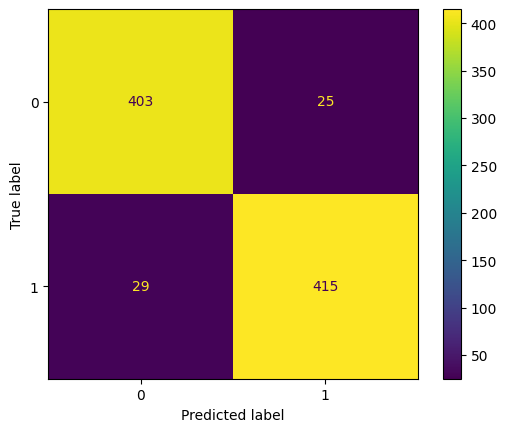

In [159]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

0.9381367348657068


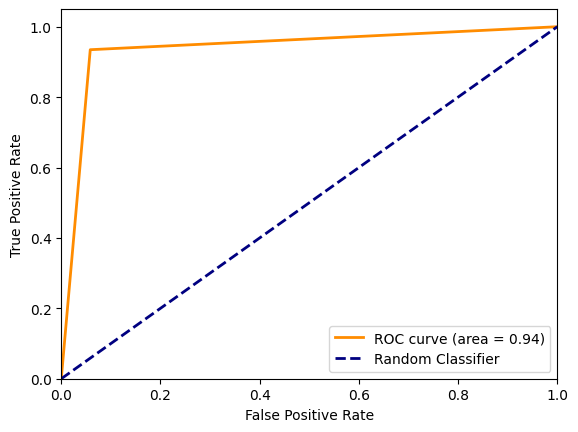

In [160]:
tpr, fpr, _ = roc_curve(labels, preds)
roc_auc = auc(tpr, fpr)
print(roc_auc)
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()

The text generation model outperforms the sentiment classification model. As T5 was trained to generate output text from input text, it is better suited to treat sentiment analysis as a text generation task rather than a classification task.

In [161]:
torch.save(model.state_dict(), f"t5-{model_size}-sst2-generation.pt")

In [162]:
local_file_path = '/content/t5-base-sst2-generation.pt'

files.download(local_file_path)

print("Download started")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started
